In [ ]:
''' 
Jupyter notebook version of the toy network consisting of a 2-in-2-out junction.
'''
### Import relevant modules
import sys
from pathlib import Path

# add parent directory to Python path
sys.path.append(str(Path().resolve().parent))

from road import Road
from junction import Junction
from network import Network
import optimization_script_parallel

import matplotlib.pyplot as plt
import numpy as np

In [2]:
### Setup the toy network

# Set global parameters for the roads
Road.dt = 0.1 # time step in seconds
Road.p_j = 200 # jam density in vehicles per mile

# Create 4 roads in the network
road1 = Road('road1')
road2 = Road('road2')
road3 = Road('road3')
road4 = Road('road4')

# Set parameters for the roads
road1.set_params(speed=20,lanes=1,length=0.5,cap=500,init_density_factor=.5)
road2.set_params(speed=20,lanes=1,length=0.5,cap=500,init_density_factor=.7)

road1.set_left_boundary_function(lambda time,sig: 0.5) # constant inflow of 0.5 vehicles per second
road2.set_left_boundary_function(lambda time,sig: 0.7) # constant inflow of 0.7 vehicles per second

road3.set_params(speed=20,lanes=1,length=0.5,cap=500,init_density_factor=0)
road4.set_params(speed=20,lanes=1,length=0.5,cap=500,init_density_factor=0)

road3.set_right_boundary_function(lambda time,sig: 0) # free outflow
road4.set_right_boundary_function(lambda time,sig: 0) # free outflow

# Create a junction connecting the roads
junction = Junction('2-in-2-out')
junction.set_roads_in(road1, road2).set_roads_out(road3, road4)

# Mark downstream roads as exit links so they evolve each step
junction.set_is_exit_junction()

# Create a network with the junction
network = Network([junction])

# Set driving preferences for the network
network.set_preferences(network.get_default_preferences())

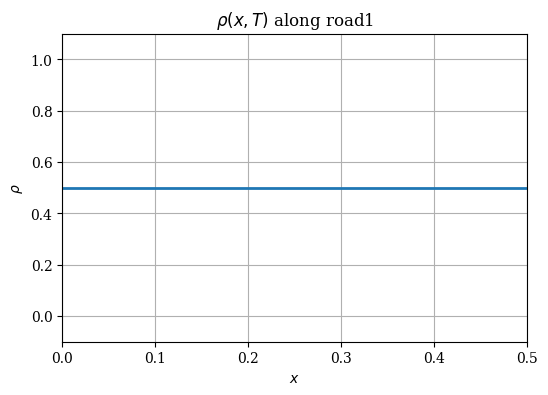

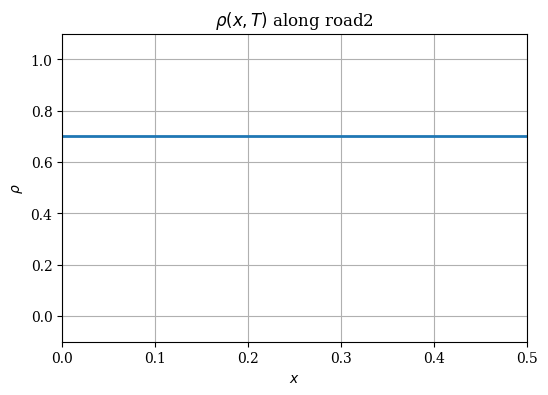

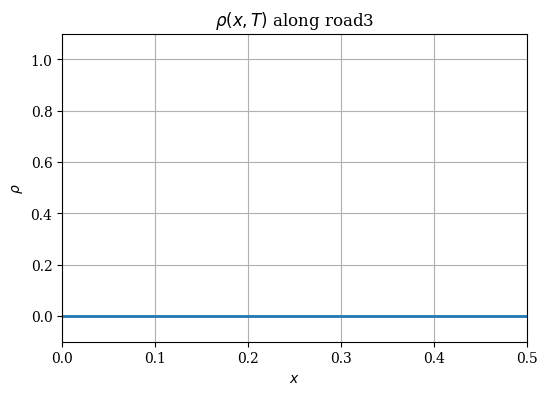

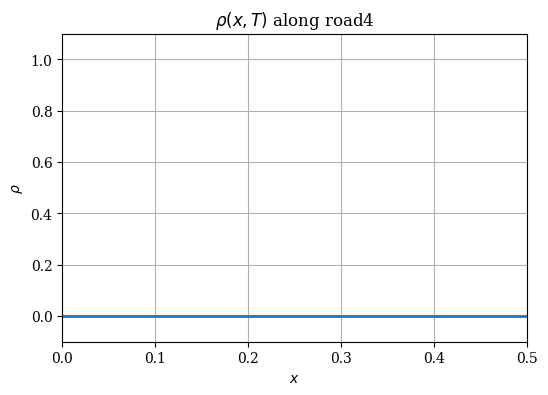

In [3]:
### Plot the roads' initial densities
road1.plot_current_density()
road2.plot_current_density()
road3.plot_current_density()
road4.plot_current_density()


In [4]:
# Simulate the network for 1000 time steps
for _ in range(1000):
    network.evolve_resolve(record_densities=True)

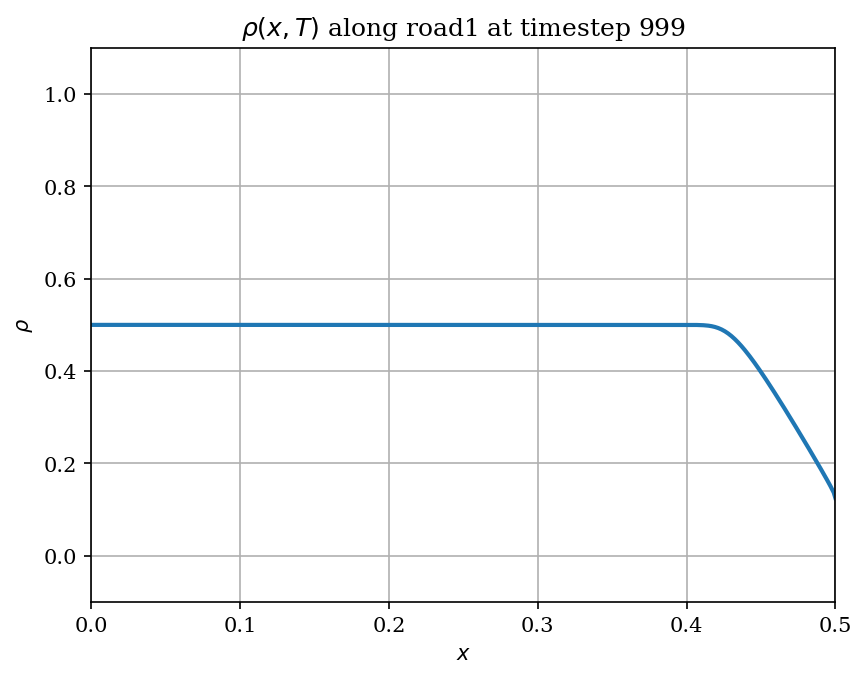

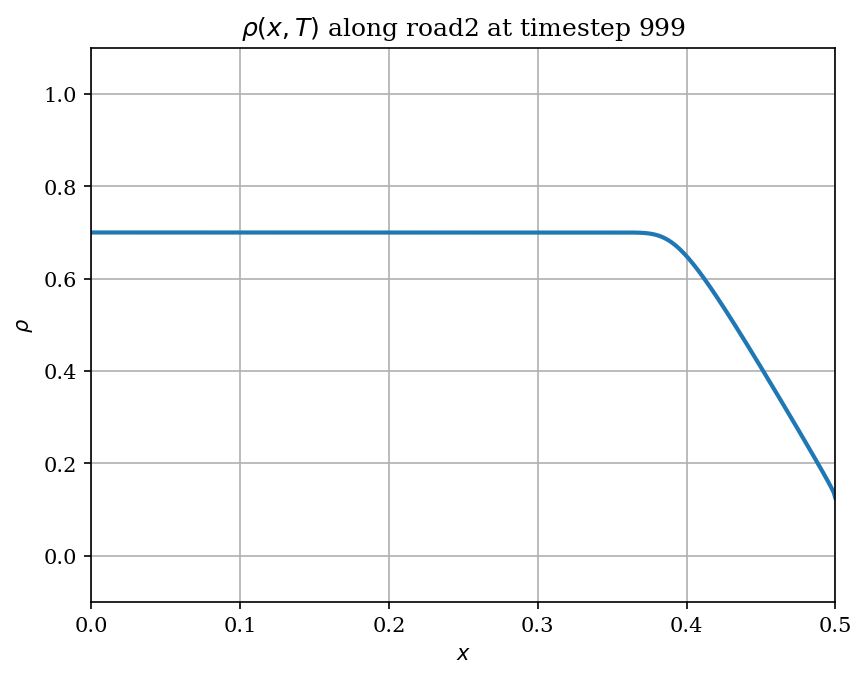

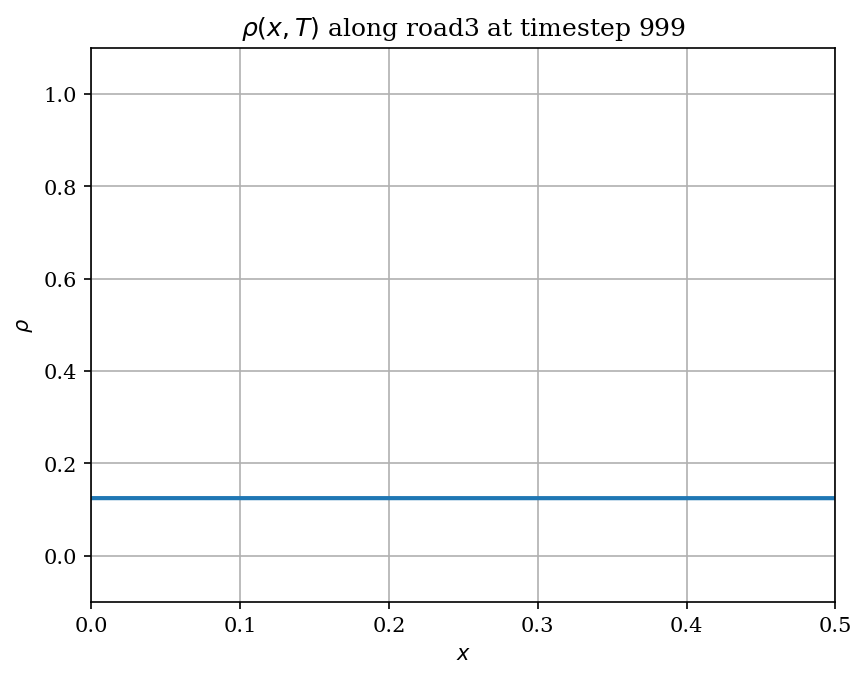

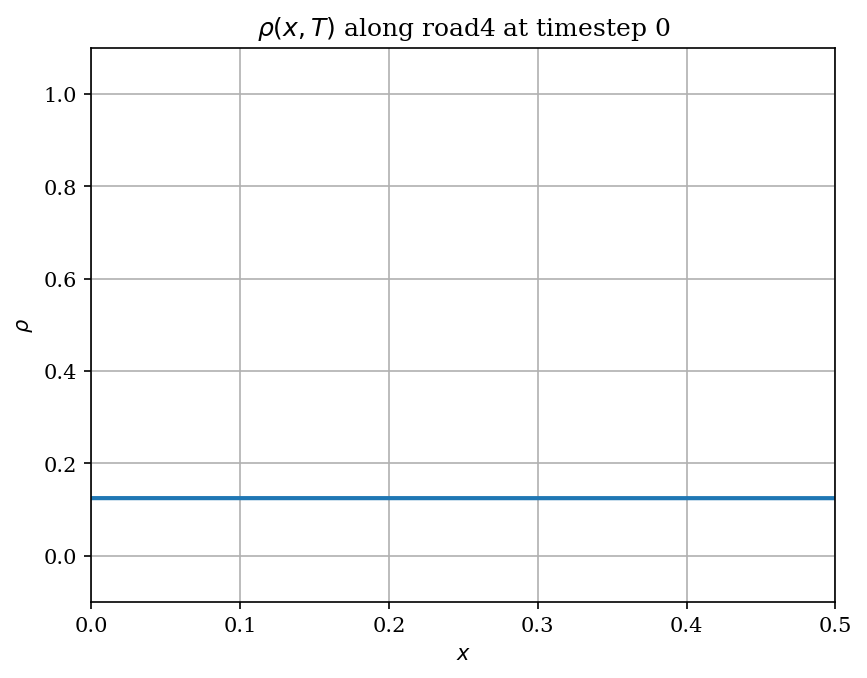

In [5]:
# Animate the roads' densities over time
road1.animate_density_history("road1_animation.gif")
road2.animate_density_history("road2_animation.gif")
road3.animate_density_history("road3_animation.gif")
road4.animate_density_history("road4_animation.gif")

Using 1 processes for parallel gradient computation
Iteration Number: 1 Out of 100
Iteration Number: 2 Out of 100
Iteration Number: 3 Out of 100
Iteration Number: 4 Out of 100
Iteration Number: 5 Out of 100
Iteration Number: 6 Out of 100
Iteration Number: 7 Out of 100
Iteration Number: 8 Out of 100
Iteration Number: 9 Out of 100
Iteration Number: 10 Out of 100
Iteration Number: 11 Out of 100
Iteration Number: 12 Out of 100
Iteration Number: 13 Out of 100
Iteration Number: 14 Out of 100
Iteration Number: 15 Out of 100
Iteration Number: 16 Out of 100
Iteration Number: 17 Out of 100
Iteration Number: 18 Out of 100
Iteration Number: 19 Out of 100
Iteration Number: 20 Out of 100
Iteration Number: 21 Out of 100
Iteration Number: 22 Out of 100
Iteration Number: 23 Out of 100
Iteration Number: 24 Out of 100
Iteration Number: 25 Out of 100
Iteration Number: 26 Out of 100
Iteration Number: 27 Out of 100
Iteration Number: 28 Out of 100
Iteration Number: 29 Out of 100
Iteration Number: 30 Out of 1

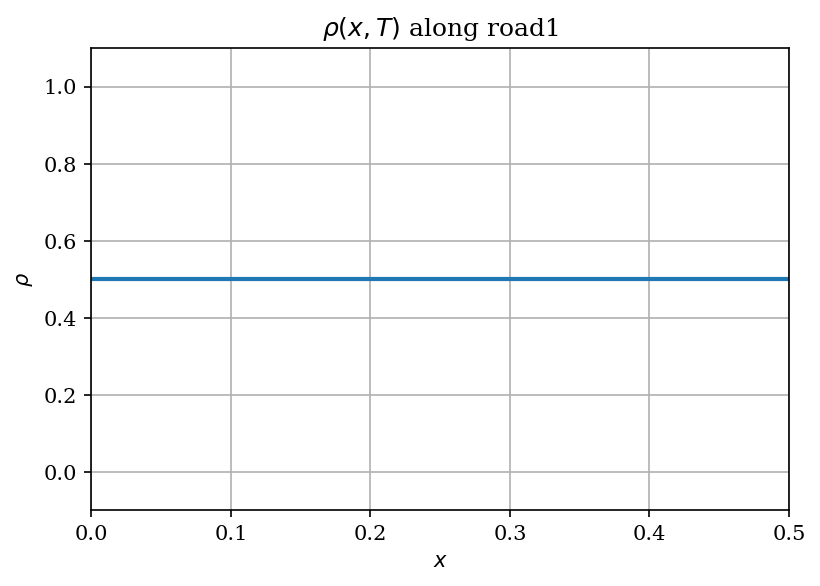

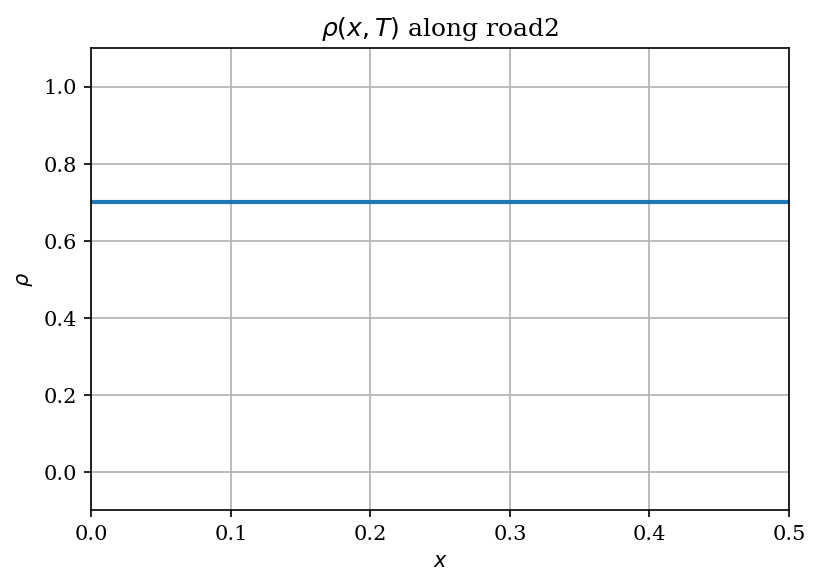

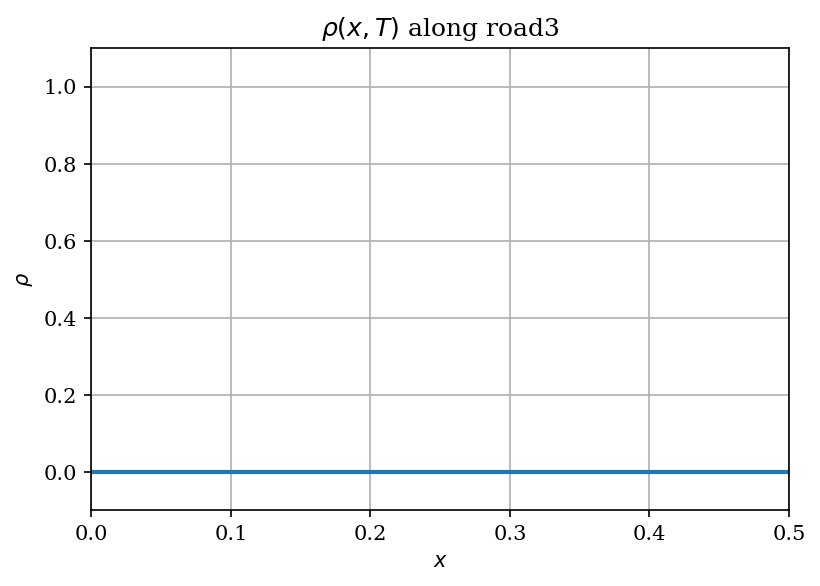

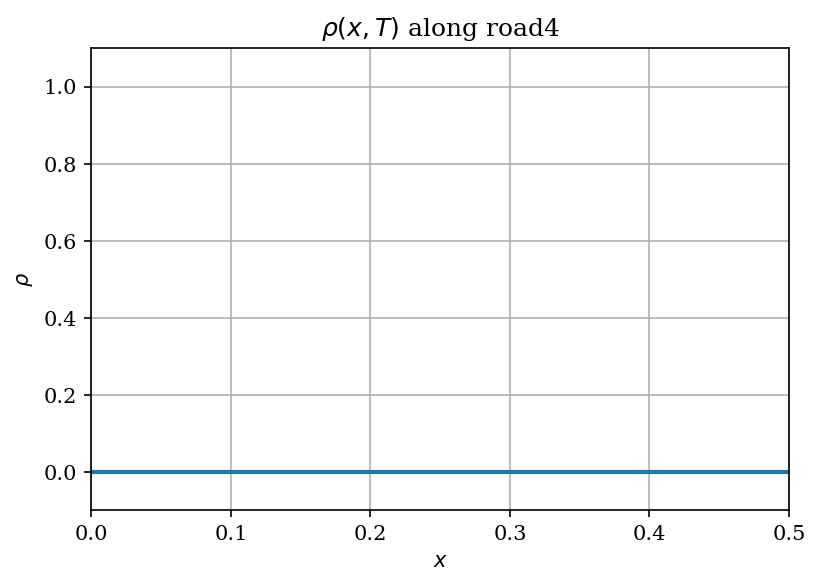

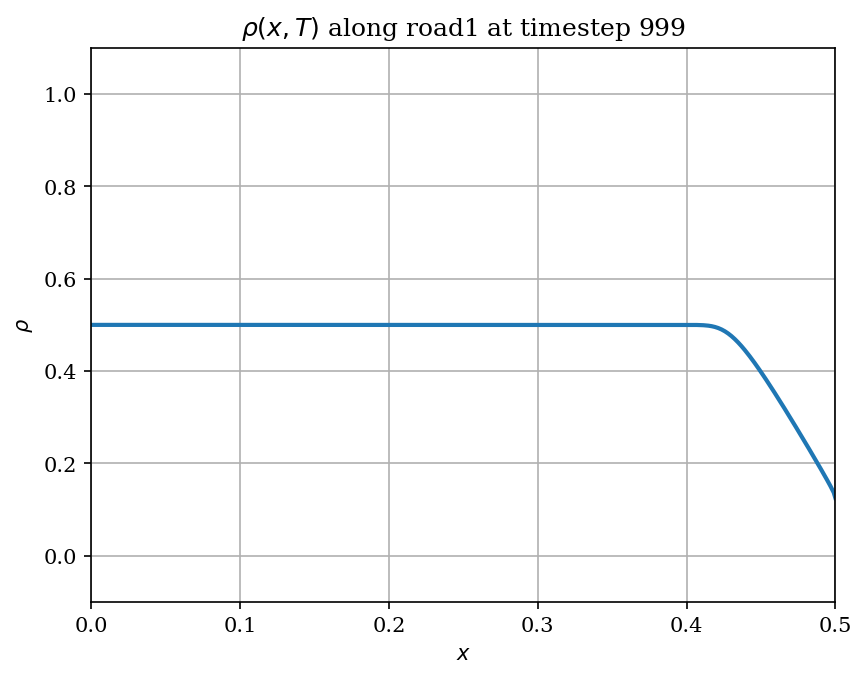

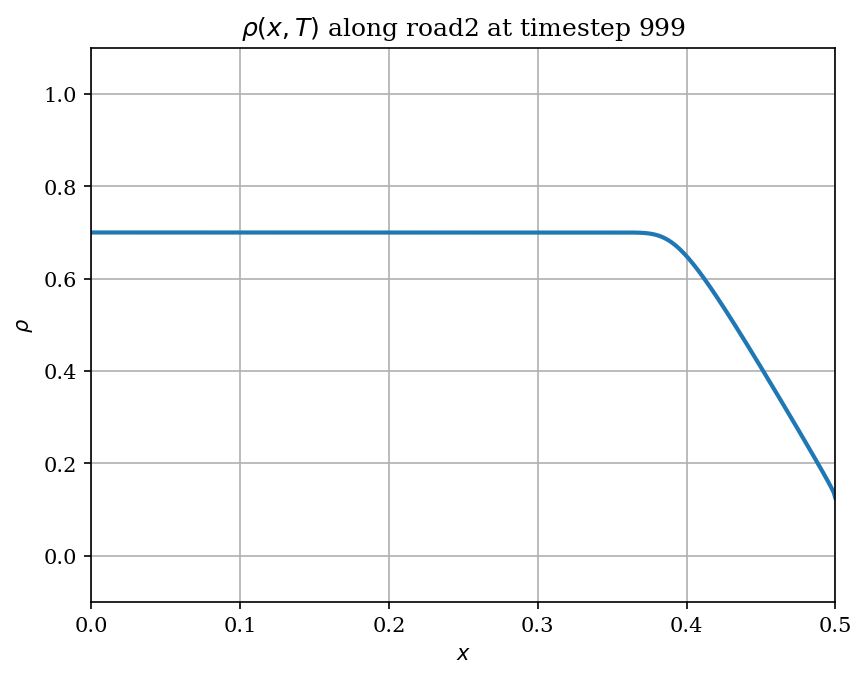

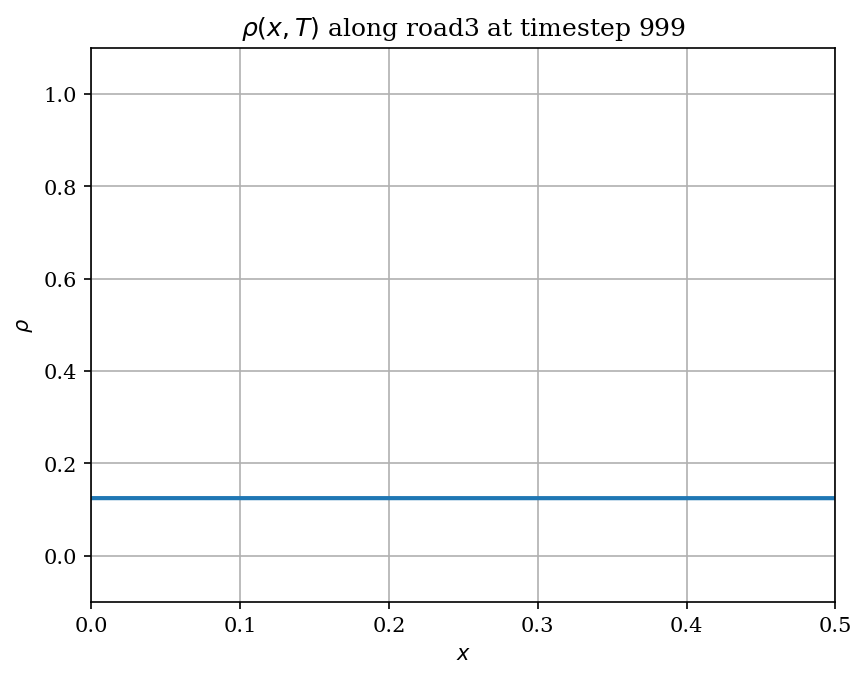

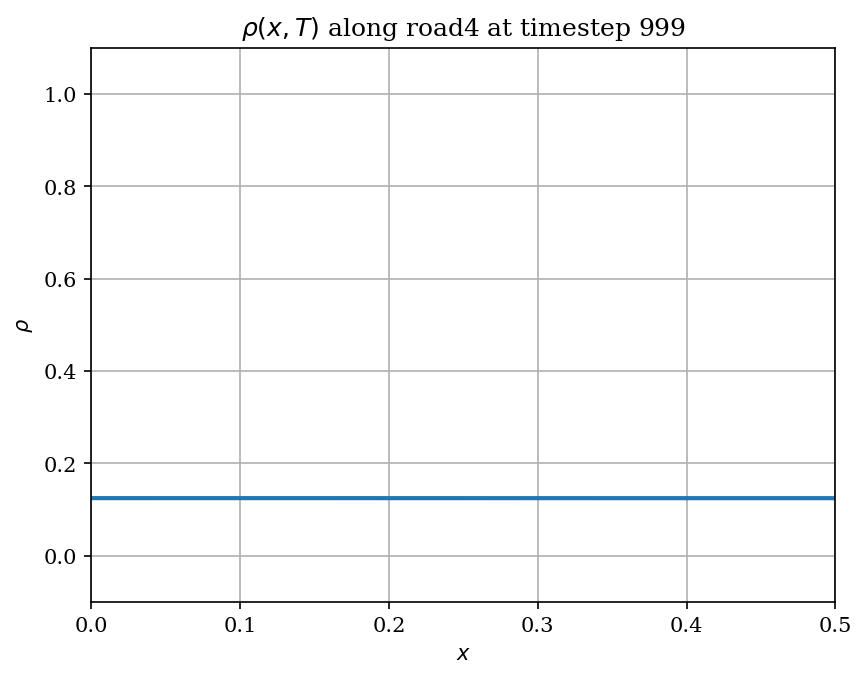

In [ ]:
### Now optimize the junction preferences and re-simulate

network.reset_by_data()  # reset the network to initial conditions
# Set the exit junction for the optimization
network.compute_distances(junction)

optimization_script_parallel.hyperparameters[-1] = 1  # number of samples for optimization, need to pick 1 here for toy example
optimization_script_parallel.run_optimization(None, network, nt_opt_val=10, output_dir="")
# Optimal parameters will be saved in toy/opt_parameters.txt
network.read_preferences("opt_parameters.txt")

# Simulate the network for 1000 time steps
for _ in range(1000):
    network.evolve_resolve(record_densities=True)

# Animate the road's densities over time
road1.animate_density_history("road1_animation.gif")
road2.animate_density_history("road2_animation.gif")
road3.animate_density_history("road3_animation.gif")
road4.animate_density_history("road4_animation.gif")